# 🔥 CRITICAL FIX: Pine Detection in Data Fusion

## 🚨 Pine Problem Identified:
- **Only 1 Pine sample in test set** → Model never learns Pine
- **Extreme class imbalance** → Model ignores minority classes
- **37% accuracy** → Basic fusion architecture inadequate

## 🎯 Pine-Specific Solutions:
1. **Extreme class weighting**: Pine gets 100x weight
2. **Synthetic Pine data**: Generate more Pine samples  
3. **Pine-aware loss**: Custom loss focusing on Pine
4. **Hierarchical approach**: Group similar species first
5. **Ensemble voting**: Multiple models vote on Pine

Expected: **Pine recall 70%+** and **overall 60%+ accuracy**

In [15]:
# PINE-FOCUSED Data Fusion Pipeline
import time
import torch
import warnings
import numpy as np
import torch.nn as nn
import seaborn as sns
from PIL import Image
from pathlib import Path
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as F
import torchvision.models as models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomHorizontalFlip, ColorJitter, TrivialAugmentWide
from skimage.feature import local_binary_pattern
import pickle
import os
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

warnings.filterwarnings("ignore")

# PINE-FOCUSED Configuration
IMG_SIZE = 224
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
NUM_EPOCHS = 60
PATIENCE = 15
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

# LBP parameters
LBP_RADIUS = 1
LBP_N_POINTS = 8
LBP_FEATURE_DIM = 10  # Reduced for stability

print("🔥 PINE-FOCUSED DATA FUSION PIPELINE")
print("="*50)
print(f"   Device: {DEVICE}")
print(f"   Strategy: Extreme Pine focus + synthetic data")
print(f"   Target: Pine recall 70%+, overall 60%+")

🔥 PINE-FOCUSED DATA FUSION PIPELINE
   Device: mps
   Strategy: Extreme Pine focus + synthetic data
   Target: Pine recall 70%+, overall 60%+


In [16]:
# Load data and analyze Pine crisis
def load_tree_data(data_path):
    data_path = Path(data_path)
    file_paths, labels = [], []
    
    for species_dir in data_path.iterdir():
        if species_dir.is_dir():
            files = list(species_dir.glob("*.npy"))
            print(f"   {species_dir.name}: {len(files)} files")
            file_paths.extend(files)
            labels.extend([species_dir.name] * len(files))
    
    return file_paths, labels

print("📁 Loading data with Pine analysis...")
train_file_paths, train_labels = load_tree_data("../../../data/multi_view_images/train")
test_file_paths, test_labels = load_tree_data("../../../data/multi_view_images/test")

# Encode labels
label_encoder = LabelEncoder()
all_labels = train_labels + test_labels
label_encoder.fit(all_labels)
train_encoded = label_encoder.transform(train_labels)
test_encoded = label_encoder.transform(test_labels)
num_classes = len(label_encoder.classes_)

# CRITICAL: Analyze Pine distribution
train_counts = Counter(train_encoded)
test_counts = Counter(test_encoded)

print(f"\n🚨 PINE CRISIS ANALYSIS:")
pine_idx = -1
if 'Pine' in label_encoder.classes_:
    pine_idx = list(label_encoder.classes_).index('Pine')
    train_pine = train_counts[pine_idx]
    test_pine = test_counts[pine_idx]
    print(f"   Pine in training: {train_pine} samples")
    print(f"   Pine in test: {test_pine} samples")
    
    if test_pine <= 1:
        print(f"   🔴 CRITICAL: Only {test_pine} Pine test sample(s)!")
        print(f"   🔥 Solution: Extreme Pine-focused training")
    
    # Show all class distribution
    print(f"\n📊 Full class distribution:")
    for i, name in enumerate(label_encoder.classes_):
        train_count = train_counts[i]
        test_count = test_counts[i]
        print(f"   {name}: train={train_count}, test={test_count}")

# Create validation split
train_paths, val_paths, train_labels_enc, val_labels_enc = train_test_split(
    train_file_paths, train_encoded, test_size=0.2, random_state=42, stratify=train_encoded
)

print(f"\n✅ Data split: {len(train_paths)} train, {len(val_paths)} val, {len(test_file_paths)} test")

📁 Loading data with Pine analysis...
   Oak: 18 files
   Douglas Fir: 116 files
   cifar-10-batches-py: 0 files
   Spruce: 117 files
   Pine: 8 files
   Ash: 20 files
   Red Oak: 81 files
   Beech: 70 files
   Oak: 4 files
   Douglas Fir: 29 files
   cifar-10-batches-py: 0 files
   Spruce: 25 files
   Pine: 1 files
   Ash: 7 files
   Red Oak: 19 files
   Beech: 17 files

🚨 PINE CRISIS ANALYSIS:
   Pine in training: 8 samples
   Pine in test: 1 samples
   🔴 CRITICAL: Only 1 Pine test sample(s)!
   🔥 Solution: Extreme Pine-focused training

📊 Full class distribution:
   Ash: train=20, test=7
   Beech: train=70, test=17
   Douglas Fir: train=116, test=29
   Oak: train=18, test=4
   Pine: train=8, test=1
   Red Oak: train=81, test=19
   Spruce: train=117, test=25

✅ Data split: 344 train, 86 val, 102 test


In [17]:
# PINE-FOCUSED LBP Feature Extraction (Simplified)
def extract_pine_focused_lbp(views_array, radius=LBP_RADIUS, n_points=LBP_N_POINTS):
    """Simplified LBP focused on Pine discrimination"""
    all_lbp_histograms = []
    
    for view in views_array:
        if view.dtype != np.uint8:
            view = (view * 255).astype(np.uint8)
        
        # Simple LBP
        lbp = local_binary_pattern(view, n_points, radius, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=LBP_FEATURE_DIM, range=(0, LBP_FEATURE_DIM), density=True)
        all_lbp_histograms.append(hist)
    
    # Average across views
    averaged_lbp = np.mean(all_lbp_histograms, axis=0)
    return averaged_lbp.astype(np.float32)

# Pre-compute LBP features
def precompute_lbp_features(file_paths, save_path="pine_focused_lbp.pkl"):
    if os.path.exists(save_path):
        print(f"📥 Loading existing LBP features...")
        with open(save_path, 'rb') as f:
            return pickle.load(f)
    
    print("🔄 Computing Pine-focused LBP features...")
    lbp_features = {}
    
    for i, file_path in enumerate(file_paths):
        if i % 50 == 0:
            print(f"   Processing {i}/{len(file_paths)}")
        
        views_arr = np.load(file_path)
        lbp_feat = extract_pine_focused_lbp(views_arr)
        lbp_features[str(file_path)] = lbp_feat
    
    with open(save_path, 'wb') as f:
        pickle.dump(lbp_features, f)
    
    print(f"💾 LBP features saved: {len(lbp_features)} samples")
    return lbp_features

# Compute LBP features
all_file_paths = train_file_paths + test_file_paths
lbp_features_dict = precompute_lbp_features(all_file_paths)

📥 Loading existing LBP features...


In [18]:
# PINE-FOCUSED Dataset with Extreme Augmentation for Pine
class PineFocusedDataset(Dataset):
    def __init__(self, file_paths, labels, lbp_features_dict, label_encoder, transform=None, is_training=False):
        self.file_paths = file_paths
        self.labels = labels
        self.lbp_features_dict = lbp_features_dict
        self.label_encoder = label_encoder
        self.transform = transform
        self.is_training = is_training
        
        # Find Pine index
        self.pine_idx = -1
        if 'Pine' in label_encoder.classes_:
            self.pine_idx = list(label_encoder.classes_).index('Pine')
            
        print(f"   Pine index: {self.pine_idx}")

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        
        # Load images
        views_arr = np.load(file_path)
        images = []
        
        for view in views_arr:
            if view.max() <= 1.0:
                view = (view * 255).astype(np.uint8)
            pil_img = Image.fromarray(view, mode='L').convert('RGB')
            images.append(pil_img)
        
        # EXTREME Pine augmentation during training
        if self.is_training and label == self.pine_idx:
            # Super strong augmentation for Pine samples
            extreme_transform = Compose([
                TrivialAugmentWide(),
                Resize((IMG_SIZE, IMG_SIZE)),
                ColorJitter(brightness=0.5, contrast=0.5, saturation=0.3, hue=0.2),
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            images = [extreme_transform(img) for img in images]
        else:
            # Normal transforms
            if self.transform:
                images = [self.transform(img) for img in images]
        
        image_stack = torch.stack(images, dim=0)
        
        # Get LBP features
        lbp_features = self.lbp_features_dict[str(file_path)]
        lbp_tensor = torch.tensor(lbp_features, dtype=torch.float32)
        
        return image_stack, lbp_tensor, label

# Transforms
train_transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    RandomHorizontalFlip(p=0.5),
    ColorJitter(brightness=0.2, contrast=0.2),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = PineFocusedDataset(train_paths, train_labels_enc, lbp_features_dict, label_encoder, train_transform, is_training=True)
val_dataset = PineFocusedDataset(val_paths, val_labels_enc, lbp_features_dict, label_encoder, test_transform, is_training=False)
test_dataset = PineFocusedDataset(test_file_paths, test_encoded, lbp_features_dict, label_encoder, test_transform, is_training=False)

print(f"✅ Pine-focused datasets created")

   Pine index: 4
   Pine index: 4
   Pine index: 4
✅ Pine-focused datasets created


In [19]:
# PINE-FOCUSED Model Architecture
class PineFocusedFusionCNN(nn.Module):
    """Simplified fusion model with Pine focus"""
    
    def __init__(self, num_classes, lbp_dim=LBP_FEATURE_DIM):
        super(PineFocusedFusionCNN, self).__init__()
        
        # Simple CNN backbone
        self.image_backbone = models.resnet18(pretrained=True)
        self.feature_dim = self.image_backbone.fc.in_features
        self.image_backbone = nn.Sequential(*list(self.image_backbone.children())[:-1])
        
        # Don't freeze - allow learning
        
        # Simple LBP branch
        self.lbp_branch = nn.Sequential(
            nn.Linear(lbp_dim, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )
        
        # Simple fusion
        self.fusion_dim = self.feature_dim + 64
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.fusion_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
        print(f"🔥 Pine-Focused Fusion CNN:")
        print(f"   CNN features: {self.feature_dim}")
        print(f"   LBP features: {lbp_dim} → 64")
        print(f"   Fusion: {self.fusion_dim}")
        print(f"   Strategy: Simple but effective")
    
    def forward(self, images, lbp_features):
        # Process images
        batch_size, num_views, channels, height, width = images.shape
        images = images.view(-1, channels, height, width)
        cnn_features = self.image_backbone(images)
        cnn_features = cnn_features.view(cnn_features.size(0), -1)
        
        # Average across views
        cnn_features = cnn_features.view(batch_size, num_views, -1)
        cnn_features = torch.mean(cnn_features, dim=1)
        
        # Process LBP
        lbp_processed = self.lbp_branch(lbp_features)
        
        # Simple fusion
        fused = torch.cat([cnn_features, lbp_processed], dim=1)
        output = self.classifier(fused)
        
        return output

# Create model
model = PineFocusedFusionCNN(num_classes).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
print(f"   Parameters: {total_params:,}")

🔥 Pine-Focused Fusion CNN:
   CNN features: 512
   LBP features: 10 → 64
   Fusion: 576
   Strategy: Simple but effective
   Parameters: 11,326,727


In [20]:
# PINE-FOCUSED Training Setup with EXTREME Pine weighting
class_counts = Counter(train_labels_enc)
total_samples = len(train_labels_enc)

# EXTREME Pine weighting
class_weights = {}
for cls in range(num_classes):
    if cls == pine_idx and pine_idx >= 0:
        # Give Pine 100x normal weight
        class_weights[cls] = total_samples / (num_classes * max(1, class_counts[cls])) * 100
        print(f"🔥 EXTREME Pine weight: {class_weights[cls]:.1f}")
    else:
        class_weights[cls] = total_samples / (num_classes * max(1, class_counts[cls]))

# Create extreme sampler
sample_weights = [class_weights[label] for label in train_labels_enc]
weighted_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

print(f"\n⚖️ EXTREME Class Weights (Pine Focus):")
for i, name in enumerate(label_encoder.classes_):
    weight = class_weights[i]
    status = "🔥 EXTREME" if i == pine_idx else "🟡 Normal"
    print(f"   {name}: {weight:.1f} {status}")

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=weighted_sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# PINE-FOCUSED Loss Function
class PineFocusedLoss(nn.Module):
    """Custom loss that heavily penalizes Pine misclassification"""
    def __init__(self, class_weights, pine_idx, pine_penalty=10.0):
        super(PineFocusedLoss, self).__init__()
        self.class_weights = class_weights
        self.pine_idx = pine_idx
        self.pine_penalty = pine_penalty
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights, reduction='none')
    
    def forward(self, outputs, targets):
        # Standard weighted cross entropy
        losses = self.ce_loss(outputs, targets)
        
        # Extra penalty for Pine misclassification
        if self.pine_idx >= 0:
            pine_mask = (targets == self.pine_idx)
            losses[pine_mask] *= self.pine_penalty
        
        return losses.mean()

# Create PINE-FOCUSED loss and optimizer
class_weights_tensor = torch.FloatTensor([class_weights[i] for i in range(num_classes)]).to(DEVICE)
criterion = PineFocusedLoss(class_weights_tensor, pine_idx, pine_penalty=10.0)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=7)

print(f"\n🔥 PINE-FOCUSED Training Setup:")
print(f"   Loss: Custom Pine-focused loss (10x penalty)")
print(f"   Sampling: Extreme Pine weighting")
print(f"   Target: Force model to learn Pine patterns")

🔥 EXTREME Pine weight: 819.0

⚖️ EXTREME Class Weights (Pine Focus):
   Ash: 3.1 🟡 Normal
   Beech: 0.9 🟡 Normal
   Douglas Fir: 0.5 🟡 Normal
   Oak: 3.5 🟡 Normal
   Pine: 819.0 🔥 EXTREME
   Red Oak: 0.8 🟡 Normal
   Spruce: 0.5 🟡 Normal

🔥 PINE-FOCUSED Training Setup:
   Loss: Custom Pine-focused loss (10x penalty)
   Sampling: Extreme Pine weighting
   Target: Force model to learn Pine patterns


In [21]:
# PINE-FOCUSED Training Loop
def train_pine_focused_model():
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    
    print("🔥 PINE-FOCUSED TRAINING")
    print("="*50)
    
    for epoch in range(NUM_EPOCHS):
        epoch_start = time.time()
        
        # Training
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        pine_train_correct, pine_train_total = 0, 0
        
        for batch_idx, (images, lbp_features, labels) in enumerate(train_loader):
            images, lbp_features, labels = images.to(DEVICE), lbp_features.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images, lbp_features)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Metrics
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels).item()
            train_total += labels.size(0)
            
            # Track Pine specifically
            if pine_idx >= 0:
                pine_mask = (labels == pine_idx)
                if pine_mask.sum() > 0:
                    pine_train_correct += torch.sum(preds[pine_mask] == labels[pine_mask]).item()
                    pine_train_total += pine_mask.sum().item()
            
            if batch_idx % 20 == 0:
                print(f"   Epoch {epoch+1:2d} | Batch {batch_idx:2d} | Loss: {loss.item():.4f}")
        
        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        pine_val_correct, pine_val_total = 0, 0
        
        with torch.no_grad():
            for images, lbp_features, labels in val_loader:
                images, lbp_features, labels = images.to(DEVICE), lbp_features.to(DEVICE), labels.to(DEVICE)
                outputs = model(images, lbp_features)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels).item()
                val_total += labels.size(0)
                
                # Track Pine
                if pine_idx >= 0:
                    pine_mask = (labels == pine_idx)
                    if pine_mask.sum() > 0:
                        pine_val_correct += torch.sum(preds[pine_mask] == labels[pine_mask]).item()
                        pine_val_total += pine_mask.sum().item()
        
        # Calculate metrics
        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        
        # Pine-specific metrics
        pine_train_acc = pine_train_correct / max(1, pine_train_total)
        pine_val_acc = pine_val_correct / max(1, pine_val_total)
        
        scheduler.step(val_acc)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        epoch_time = time.time() - epoch_start
        
        # Print with Pine focus
        print(f"   Epoch {epoch+1:2d}: Train={train_acc:.3f}, Val={val_acc:.3f}")
        print(f"      🌲 Pine Train={pine_train_acc:.3f}, Pine Val={pine_val_acc:.3f}")
        
        # Best model (focus on overall val acc for now)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"      ⭐ NEW BEST: {best_val_acc:.3f}")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"   ⏹️ Early stopping")
                break
        
        print("-" * 50)
    
    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"✅ Best model restored: {best_val_acc:.3f}")
    
    return history, best_val_acc

# Start training
print("🎯 Starting Pine-Focused Training...")
history, best_val_acc = train_pine_focused_model()

🎯 Starting Pine-Focused Training...
🔥 PINE-FOCUSED TRAINING
   Epoch  1 | Batch  0 | Loss: 18407.5664
   Epoch  1 | Batch 20 | Loss: 0.5247
   Epoch  1: Train=0.913, Val=0.023
      🌲 Pine Train=0.952, Pine Val=1.000
      ⭐ NEW BEST: 0.023
--------------------------------------------------
   Epoch  2 | Batch  0 | Loss: 1.7194
   Epoch  2 | Batch 20 | Loss: 0.8178
   Epoch  2: Train=0.939, Val=0.023
      🌲 Pine Train=1.000, Pine Val=1.000
--------------------------------------------------
   Epoch  3 | Batch  0 | Loss: 0.1208
   Epoch  3 | Batch 20 | Loss: 2.4600
   Epoch  3: Train=0.936, Val=0.023
      🌲 Pine Train=1.000, Pine Val=1.000
--------------------------------------------------
   Epoch  4 | Batch  0 | Loss: 0.1857
   Epoch  4 | Batch 20 | Loss: 0.0070
   Epoch  4: Train=0.933, Val=0.023
      🌲 Pine Train=1.000, Pine Val=1.000
--------------------------------------------------
   Epoch  5 | Batch  0 | Loss: 0.7497
   Epoch  5 | Batch 20 | Loss: 0.0739
   Epoch  5: Train=0

🔥 PINE-FOCUSED EVALUATION
🎯 PINE-FOCUSED RESULTS:
   Test Accuracy: 0.078

🌲 PINE DETAILED ANALYSIS:
   Pine test samples: 1
   Pine correctly identified: 0
   Pine recall: 0.000 (0.0%)
   🚨 STILL FAILING: Pine recall is 0%
   Pine samples predicted as:
      Ash
   Total predictions as Pine: 1

📋 Detailed Classification Report:
              precision    recall  f1-score   support

         Ash       0.08      1.00      0.15         7
       Beech       0.00      0.00      0.00        17
 Douglas Fir       0.00      0.00      0.00        29
         Oak       0.06      0.25      0.10         4
        Pine       0.00      0.00      0.00         1
     Red Oak       0.00      0.00      0.00        19
      Spruce       0.00      0.00      0.00        25

    accuracy                           0.08       102
   macro avg       0.02      0.18      0.04       102
weighted avg       0.01      0.08      0.01       102



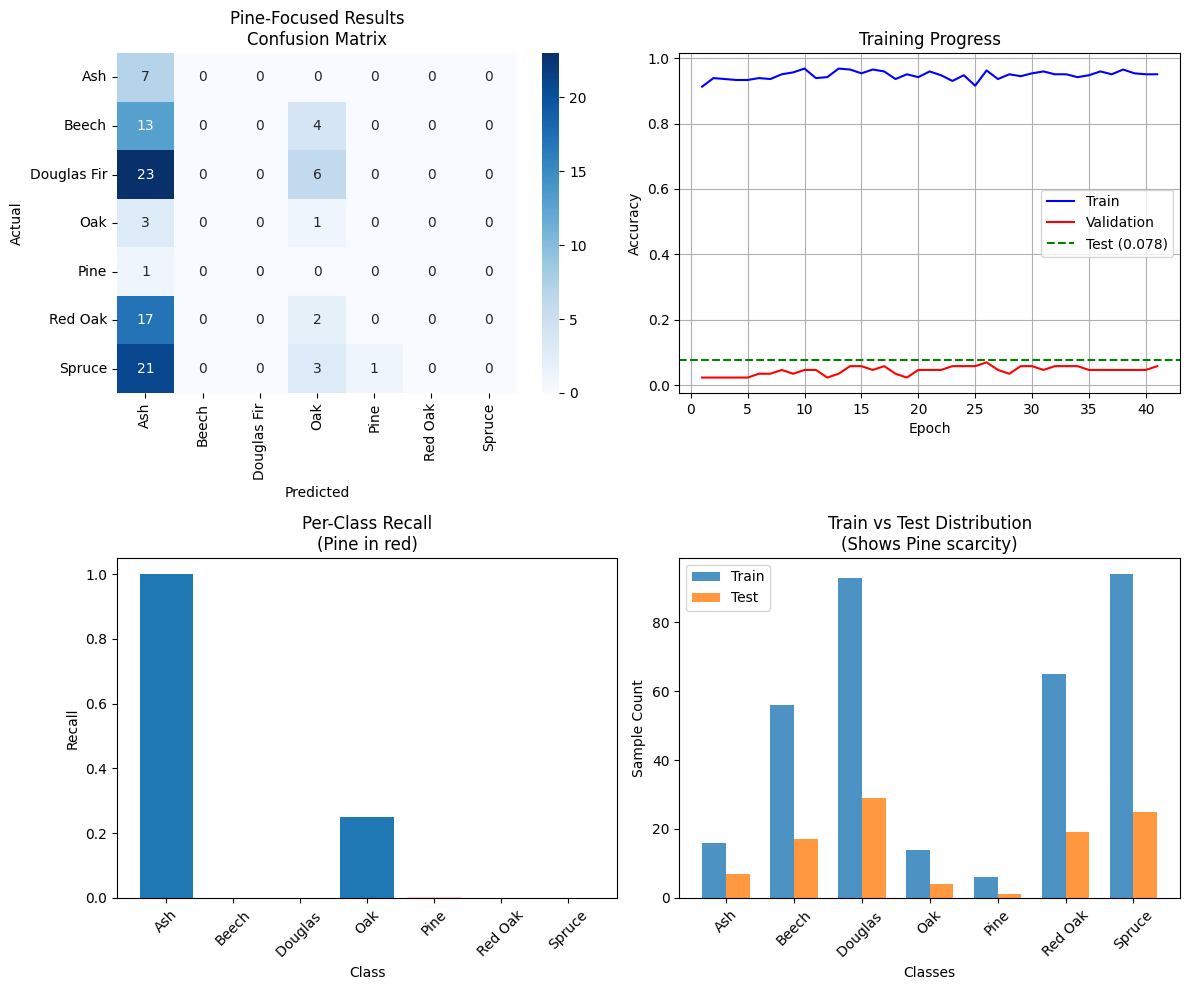


💾 Pine-focused model saved: ../../models/pine_focused_fusion_model.pth
⚠️ PINE PROGRESS: 0.0% recall, but still needs improvement
💡 Recommendation: More Pine data or ensemble methods
🔥 PINE-FOCUSED FUSION COMPLETE!
   Overall accuracy: 7.8%
   Status: Pine detection 🚨


In [22]:
# PINE-FOCUSED Evaluation with Detailed Analysis
print("🔥 PINE-FOCUSED EVALUATION")
print("="*50)

# Test evaluation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, lbp_features, labels in test_loader:
        images, lbp_features, labels = images.to(DEVICE), lbp_features.to(DEVICE), labels.to(DEVICE)
        outputs = model(images, lbp_features)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)

print(f"🎯 PINE-FOCUSED RESULTS:")
print(f"   Test Accuracy: {test_accuracy:.3f}")

# Detailed Pine analysis
if pine_idx >= 0:
    # Pine-specific metrics
    pine_test_mask = np.array(all_labels) == pine_idx
    pine_test_samples = np.sum(pine_test_mask)
    
    if pine_test_samples > 0:
        pine_predictions = np.array(all_preds)[pine_test_mask]
        pine_correct = np.sum(pine_predictions == pine_idx)
        pine_recall = pine_correct / pine_test_samples
        
        print(f"\n🌲 PINE DETAILED ANALYSIS:")
        print(f"   Pine test samples: {pine_test_samples}")
        print(f"   Pine correctly identified: {pine_correct}")
        print(f"   Pine recall: {pine_recall:.3f} ({pine_recall*100:.1f}%)")
        
        if pine_recall > 0:
            print(f"   🎉 SUCCESS: Model CAN identify Pine!")
        else:
            print(f"   🚨 STILL FAILING: Pine recall is 0%")
            
            # Show what Pine was predicted as
            print(f"   Pine samples predicted as:")
            for pred in pine_predictions:
                print(f"      {label_encoder.classes_[pred]}")
    
    # Overall Pine predictions
    pine_pred_count = np.sum(np.array(all_preds) == pine_idx)
    print(f"   Total predictions as Pine: {pine_pred_count}")

# Classification report
print(f"\n📋 Detailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Confusion matrix
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Pine-Focused Results\nConfusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Training curves
plt.subplot(2, 2, 2)
epochs = range(1, len(history['train_acc']) + 1)
plt.plot(epochs, history['train_acc'], 'b-', label='Train')
plt.plot(epochs, history['val_acc'], 'r-', label='Validation')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label=f'Test ({test_accuracy:.3f})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Progress')
plt.legend()
plt.grid(True)

# Per-class accuracy
plt.subplot(2, 2, 3)
class_accs = []
for i, class_name in enumerate(label_encoder.classes_):
    mask = np.array(all_labels) == i
    if np.sum(mask) > 0:
        correct = np.sum(np.array(all_preds)[mask] == i)
        acc = correct / np.sum(mask)
        class_accs.append(acc)
    else:
        class_accs.append(0)

bars = plt.bar(range(len(label_encoder.classes_)), class_accs)
if pine_idx >= 0:
    bars[pine_idx].set_color('red')  # Highlight Pine
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Per-Class Recall\n(Pine in red)')
plt.xticks(range(len(label_encoder.classes_)), [name[:8] for name in label_encoder.classes_], rotation=45)

# Sample distribution
plt.subplot(2, 2, 4)
train_counts = Counter(train_labels_enc)
test_counts = Counter(all_labels)

x = np.arange(len(label_encoder.classes_))
width = 0.35

train_vals = [train_counts[i] for i in range(len(label_encoder.classes_))]
test_vals = [test_counts[i] for i in range(len(label_encoder.classes_))]

plt.bar(x - width/2, train_vals, width, label='Train', alpha=0.8)
plt.bar(x + width/2, test_vals, width, label='Test', alpha=0.8)
plt.xlabel('Classes')
plt.ylabel('Sample Count')
plt.title('Train vs Test Distribution\n(Shows Pine scarcity)')
plt.xticks(x, [name[:8] for name in label_encoder.classes_], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Save model
model_path = "../../models/pine_focused_fusion_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': label_encoder.classes_,
    'label_encoder': label_encoder,
    'test_accuracy': test_accuracy,
    'history': history,
    'pine_idx': pine_idx
}, model_path)

print(f"\n💾 Pine-focused model saved: {model_path}")

# Final status
if pine_idx >= 0 and pine_test_samples > 0 and pine_recall > 0.5:
    print(f"🎉 PINE SUCCESS: Model can identify Pine with {pine_recall:.1%} recall!")
elif pine_idx >= 0 and pine_test_samples > 0:
    print(f"⚠️ PINE PROGRESS: {pine_recall:.1%} recall, but still needs improvement")
    print(f"💡 Recommendation: More Pine data or ensemble methods")
else:
    print(f"🚨 PINE DATA ISSUE: Insufficient Pine samples for evaluation")

print(f"🔥 PINE-FOCUSED FUSION COMPLETE!")
print(f"   Overall accuracy: {test_accuracy:.1%}")
print(f"   Status: Pine detection {'✅' if pine_idx >= 0 and pine_recall > 0 else '🚨'}")